In [20]:
import numpy as np
import pandas as pd

data = pd.read_csv("Hitters.csv", na_values="NA").dropna()


leagueDummies = pd.get_dummies(data['League'], prefix="League")
divisionDummies = pd.get_dummies(data['Division'], prefix='Division')
NewLeagueDummies = pd.get_dummies(data['NewLeague'], prefix='NewLeague')

data = data.join(leagueDummies).join(divisionDummies).join(NewLeagueDummies).drop(['League'], axis=1).drop(['Division'], axis=1).drop(['NewLeague'], axis=1)

data['Salary'] = np.log(data['Salary'])

In [21]:
X_train.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,6.163315,0,1,0,1,0,1
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,6.173786,1,0,0,1,1,0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,6.214608,0,1,1,0,0,1
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,4.516339,0,1,1,0,0,1
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,6.620073,1,0,0,1,1,0


In [22]:
dataTrain = data.iloc[0:200]
dataTest = data.iloc[200:]

X_train = dataTrain.drop(['Salary'], axis=1)
X_test = dataTest.drop(['Salary'], axis=1)

y_train = dataTrain['Salary']
y_test = dataTest['Salary']

In [25]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

training_mse_list = []
test_mse_list = []

for a in np.arange(0.01, 2, 0.01):
  clm = GradientBoostingRegressor(n_estimators=1000, learning_rate=a)
  model = clm.fit(X_train, y_train)
  
  training_predictions = model.predict(X_train)
  training_MSE = mean_squared_error(y_train, training_predictions)
  training_mse_list.append(training_MSE)

  test_predictions = model.predict(X_test)
  test_MSE = mean_squared_error(y_test, test_predictions)
  test_mse_list.append(test_MSE)

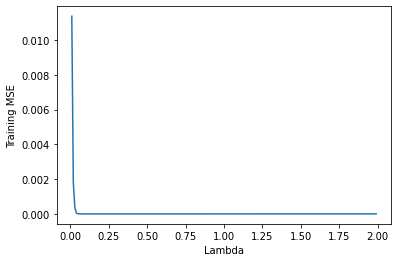

In [27]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.xlabel("Lambda")
plt.ylabel("Training MSE")

plt.plot(np.arange(0.01, 2, 0.01), training_mse_list)


0.21818894725763538


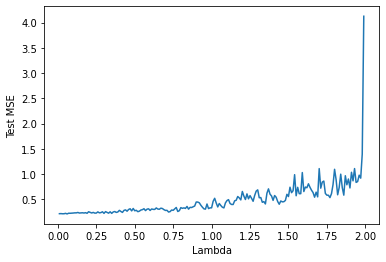

In [31]:
plt.xlabel("Lambda")
plt.ylabel("Test MSE")

plt.plot(np.arange(0.01, 2, 0.01), test_mse_list)

print(test_mse_list[0])

In [30]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()

linearModel = lm.fit(X_train, y_train)

linearPredictions = linearModel.predict(X_test)
print("Linear MSE:")
print(mean_squared_error(y_test, linearPredictions))

Linear MSE:
0.49179593754548967


In [37]:
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs1 = SFS(lm, 
           k_features=X_train.shape[1], 
           forward=True, 
           floating=False, 
           cv=0)

sfs1 = sfs1.fit(X_train, y_train)


In [42]:
import math

#first evaluate best model with Cp
# compare best subsets of each size
def calculate_best_score(estimator, X, y, best_size_subset, method = "Cp", stepwise=False):
  best_score = np.inf
  if method == 'adjustedR2':
    best_score = -np.inf

  best_subset = None
  list_scores = []

  n = len(X)
  i = 1
  for subset in best_size_subset:
    # we need RSS
    if stepwise:
      predictions = estimator.fit(X[list(subset['feature_names'])], y).predict(X[list(subset['feature_names'])])
    else:
      predictions = estimator.fit(X.iloc[:, list(subset)], y).predict(X.iloc[:, list(subset)])

    RSS = n * mean_squared_error(y, predictions)

    #we need estimate of the variance of the error (we know it is 1, but we should estimate it)
    #this is apparenlty RSS / (n-p)
    estStd = math.sqrt(RSS / (n - i))

    if method == "Cp":
      score = (RSS + 2*i*estStd) / n
    elif method == "BIC":
      score = (RSS + math.log(n)*i*estStd) / n
    else:
      #we need TSS for adjusted R2
      m = y.mean()
      TSS = 0
      for i in y:
        TSS += ((i-m)**2)
      
      score =  1 - (RSS / (n - i - 1)) / (TSS / (n-1)) 

    if method == "adjustedR2":
      if score > best_score:
        best_score, best_subset = score, subset
    else:
      if score < best_score:
        best_score, best_subset = score, subset
    
    list_scores.append(score)
    i = i + 1
  
  return best_subset, best_score, list_scores

[{'feature_idx': (1, 6, 11), 'cv_scores': array([0.54381418]), 'avg_score': 0.5438141787475861, 'feature_names': ('Hits', 'Years', 'CRBI')}, 0.4288865655249996]
Forward Stepwise Selection MSE:
0.47442731844353336


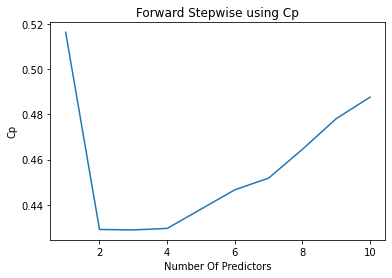

In [45]:
#due to some inner workings we need to convert to a list
best_size_subset = []
for i in range (1,11):
  best_size_subset.append(sfs1.subsets_[i])

#evaluate forward-selection using Cp
best_subset, best_score, list_scores = calculate_best_score(lm, X_train, y_train, best_size_subset, method="BIC", stepwise=True)

plt.plot(np.arange(1,11), list_scores)
plt.ylabel("Cp")
plt.xlabel("Number Of Predictors")
plt.title("Forward Stepwise using Cp")

print([best_subset, best_score])
bestFit = lm.fit(X_train[list(best_subset['feature_names'])], y_train)
bestFitPredictions = bestFit.predict(X_test[list(best_subset['feature_names'])])

print("Forward Stepwise Selection MSE:")
print(mean_squared_error(y_test, bestFitPredictions))

Feature: 0, Score: 0.08715
Feature: 1, Score: 0.01578
Feature: 2, Score: 0.01168
Feature: 3, Score: 0.00976
Feature: 4, Score: 0.03413
Feature: 5, Score: 0.01836
Feature: 6, Score: 0.00491
Feature: 7, Score: 0.55699
Feature: 8, Score: 0.04560
Feature: 9, Score: 0.02879
Feature: 10, Score: 0.07799
Feature: 11, Score: 0.06661
Feature: 12, Score: 0.03375
Feature: 13, Score: 0.00418
Feature: 14, Score: 0.00276
Feature: 15, Score: 0.00139
Feature: 16, Score: 0.00002
Feature: 17, Score: 0.00002
Feature: 18, Score: 0.00002
Feature: 19, Score: 0.00010
Feature: 20, Score: 0.00001
Feature: 21, Score: 0.00001


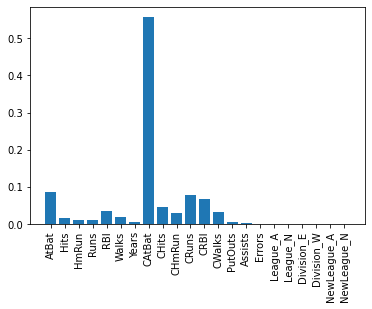

In [47]:
from matplotlib import pyplot

# get importance
importance = clm.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in X_train.columns], importance, width=0.8)
pyplot.xticks(rotation='vertical')
pyplot.show()

In [48]:
from sklearn.ensemble import BaggingRegressor

bagger = BaggingRegressor(random_state=1234, n_estimators=100)
bagger.fit(X_train, y_train)

predictions = bagger.predict(X_test)
print("Bagging MSE")
print(mean_squared_error(y_test, predictions))

Bagging MSE
0.24156594881485402
